# <center>使用人工智能预测学生成绩</center>


## 01 背景介绍
随着教育数据的不断积累和技术的发展，机器学习在教育领域的应用日益广泛。其中，预测学生成绩是机器学习在教育领域的一个重要应用方向之一。通过分析学生的个人信息（如性别、年龄、家庭背景）、学术数据（如历史考试成绩、课堂表现）以及其他相关因素（如学校类型、教学资源），机器学习模型可以建立起学生成绩与这些因素之间的关联，并据此进行预测。家长和学生可据此调整学习策略，提高学习效率。


## 02 数据说明
- 文件列表
该数据集包含1个文件：
    - `student-mat.csv`
- 属性描述：
  离散特征包括学校、性别、家庭地址、家庭规模、父母的职业、学习原因、监护人、学校支持情况、家庭支持情况、是否付费辅导、课外活动情况、是否上幼儿园、是否希望上大学、互联网接入情况、恋爱情况。
而数值特征包括学生的年龄、父母的教育水平、通勤时间、学习时间、失败次数、家庭关系、空闲时间、外出频率、工作日和周末饮酒情况、健康状况、缺勤次数，以及三次数学成绩（G1、G2、G3）。
  

## 03 加载数据集

In [77]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE

# 加载数据集
data = pd.read_csv("student-mat.csv")
# 数据维度
raws,cols = data.shape
print(f"该数据集{raws}个样本")
print(f"该数据集有{cols-1}个特征")

该数据集395个样本
该数据集有32个特征


### 3.1、 探索性数据分析(EDA)

In [78]:
# 探索性数据分析（EDA）
print("数据集的前几行：")
print(data.head())

print("\n数据集的基本信息：")
print(data.info())

print("\n数据集的描述统计信息：")
print(data.describe())

数据集的前几行：
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

数据集的基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 

### 3.2、特征工程

In [79]:
# 确定离散特征和数值特征
discrete_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

# 打印离散特征和数值特征
print("\n离散特征：", discrete_features)
print("\n数值特征：", numerical_features)

# 对离散特征进行独热编码
data = pd.get_dummies(data, columns=discrete_features)



离散特征： Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

数值特征： Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')


### 3.3、将离散数学成绩转化为有序的类别

In [80]:
# 将离散的数学成绩（G1, G2, G3）转化为有序类别
def convert_to_continuous(x):
    x = int(x)
    if x < 5:
        return 1  # 差
    elif 5 <= x < 10:
        return 2  # 中
    elif 10 <= x < 15:
        return 3  # 好
    else:
        return 4  # 优

data['G1'] = data['G1'].apply(convert_to_continuous)
data['G2'] = data['G2'].apply(convert_to_continuous)
data['G3'] = data['G3'].apply(convert_to_continuous)

### 3.4、数据可视化

#### 1、箱型图

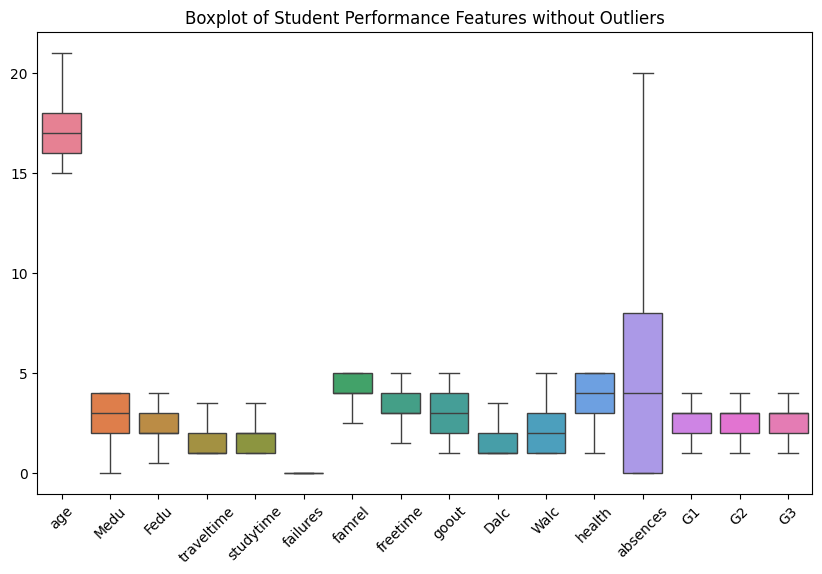

In [81]:
# 确保数据集中只包含数值型特征
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

# 第一次做出箱型图发现有离群值，因此先替换离群值
def replace_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
# 替换离群值并绘制箱型图
data_no_outliers = data[numerical_features].apply(replace_outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_no_outliers)
plt.title("Boxplot of Student Performance Features without Outliers")
plt.xticks(rotation=45)
plt.show()

#### 2、特征重要性图

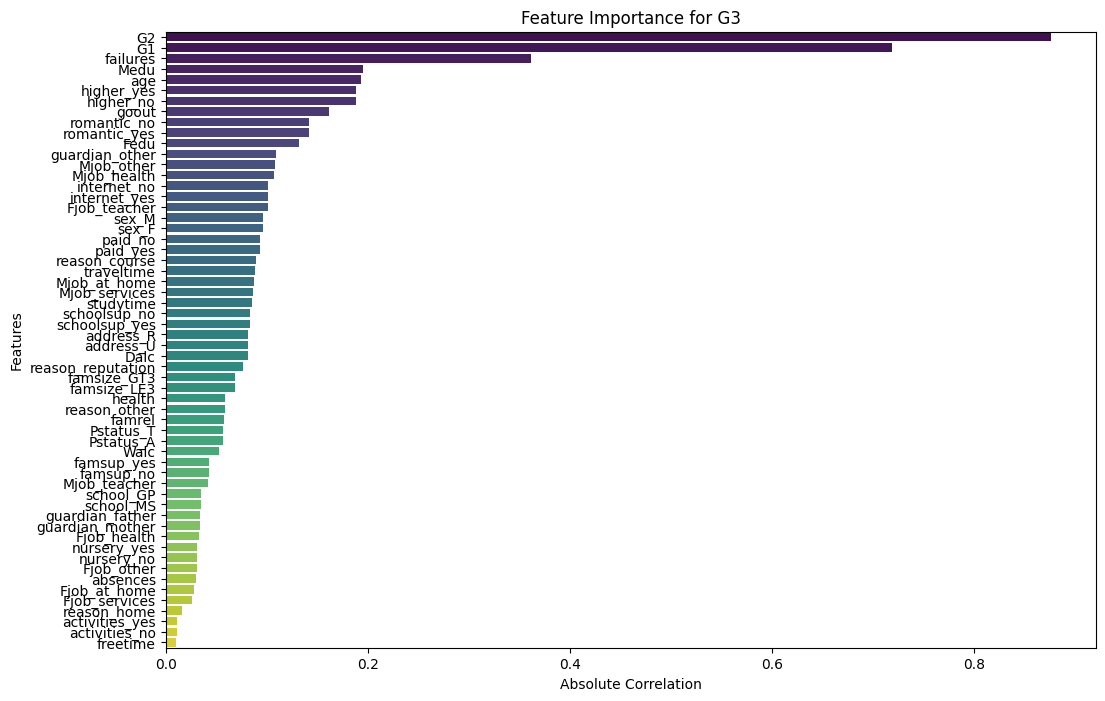

In [82]:
# 计算特征与目标变量（G3）之间的相关性
correlation = data.corr()['G3'].drop('G3')

# 排序特征重要性
sorted_features = correlation.abs().sort_values(ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index, hue=sorted_features.index, palette="viridis", legend=False)
plt.title("Feature Importance for G3")
plt.xlabel("Absolute Correlation")
plt.ylabel("Features")
plt.show()

#### 3、热力图

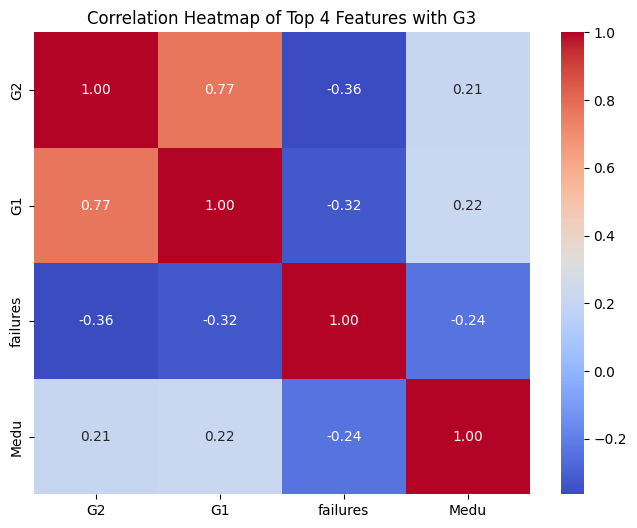

In [83]:
# 相关性前四的特征
top_features = sorted_features.head(4).index

# 选取特征与目标变量（G3）之间的相关性
top_correlation = data[top_features].corr()

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(top_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Top 4 Features with G3')
plt.show()

### 3.5、特征选择

In [84]:
# 特征选择：选择相关性较高的特征，即前20个特征
correlation = data.corr()['G3'].drop('G3')
sorted_features = correlation.abs().sort_values(ascending=False)
top_features = sorted_features.head(20).index
# 选择特征和目标变量
X = data[top_features]
y = data['G3']

### 3.6、对选择特征进行标准化

In [85]:
#标准化特征可以确保模型在训练过程中更快地收敛，并且不会因为特征的尺度不同而对模型产生偏见。
#这里只对选择特征进行标准化，而对目标特征不做处理
# 创建一个标准化器对象
scaler = StandardScaler()

# 对特征进行标准化
X_scaled = scaler.fit_transform(X)

## 04 切分数据集

In [86]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 查看划分后的训练集和测试集大小
print("\n训练集大小:", X_train.shape, y_train.shape)
print("测试集大小:", X_test.shape, y_test.shape)


训练集大小: (316, 20) (316,)
测试集大小: (79, 20) (79,)


## 05 构建模型并评估，然后调优

### 5.1、构建三种模型并评估

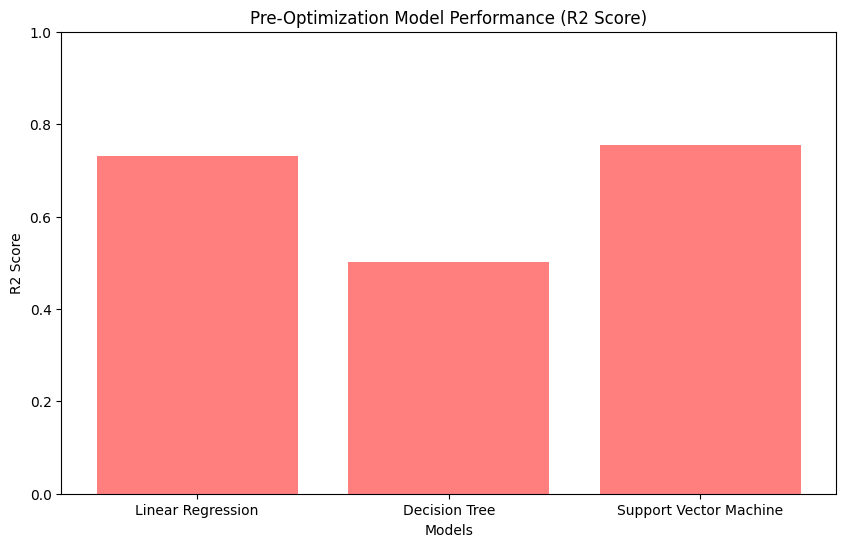

Pre-Optimization Scores for Linear Regression:
MSE: 0.2047018408566488, R2: 0.7312696279372434, MAE: 0.2679490479180362
Pre-Optimization Scores for Decision Tree:
MSE: 0.379746835443038, R2: 0.5014724442574674, MAE: 0.35443037974683544
Pre-Optimization Scores for Support Vector Machine:
MSE: 0.1871975295949215, R2: 0.7542490992423423, MAE: 0.2562333019282212


In [87]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR()
}

pre_optimization_scores = {}
post_optimization_scores = {}

# 记录调优前的性能指标
plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_pre = model.predict(X_test)
    mse_pre = mean_squared_error(y_test, y_pred_pre)
    r2_pre = r2_score(y_test, y_pred_pre)
    mae_pre = mean_absolute_error(y_test, y_pred_pre)
    pre_optimization_scores[name] = {"MSE": mse_pre, "R2": r2_pre, "MAE": mae_pre}
# 可视化调优前性能
    plt.bar(name, r2_pre, color='red', alpha=0.5)
plt.title("Pre-Optimization Model Performance (R2 Score)")
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.ylim(0, 1)
plt.show()
best_models = {}
# 输出每个模型的调优前性能指标
for name, scores in pre_optimization_scores.items():
    print(f"Pre-Optimization Scores for {name}:")
    print(f"MSE: {scores['MSE']}, R2: {scores['R2']}, MAE: {scores['MAE']}")

### 5.2、对模型进行调优

In [88]:
# 模型参数调优
for name, model in models.items():
    if name == "Linear Regression":
        best_model = model
    elif name == "Decision Tree":
        param_grid = {'max_depth': [None, 5, 10, 15]}
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:  # SVM
        param_grid = {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1]}
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    
    best_models[name] = best_model

    # 记录调优后的性能指标
    y_pred_post = best_model.predict(X_test)
    mse_post = mean_squared_error(y_test, y_pred_post)
    r2_post = r2_score(y_test, y_pred_post)
    mae_post = mean_absolute_error(y_test, y_pred_post)
    post_optimization_scores[name] = {"MSE": mse_post, "R2": r2_post, "MAE": mae_post}

### 5.3、可视化调优后模型性能，并选出最优模型


Post-Optimization Scores for Linear Regression:
MSE: 0.2047018408566488, R2: 0.7312696279372434, MAE: 0.2679490479180362

Post-Optimization Scores for Decision Tree:
MSE: 0.20993109115702838, R2: 0.7244047244612928, MAE: 0.24638524543215545

Post-Optimization Scores for Support Vector Machine:
MSE: 0.18763492293285253, R2: 0.7536748939789792, MAE: 0.22489203223635043


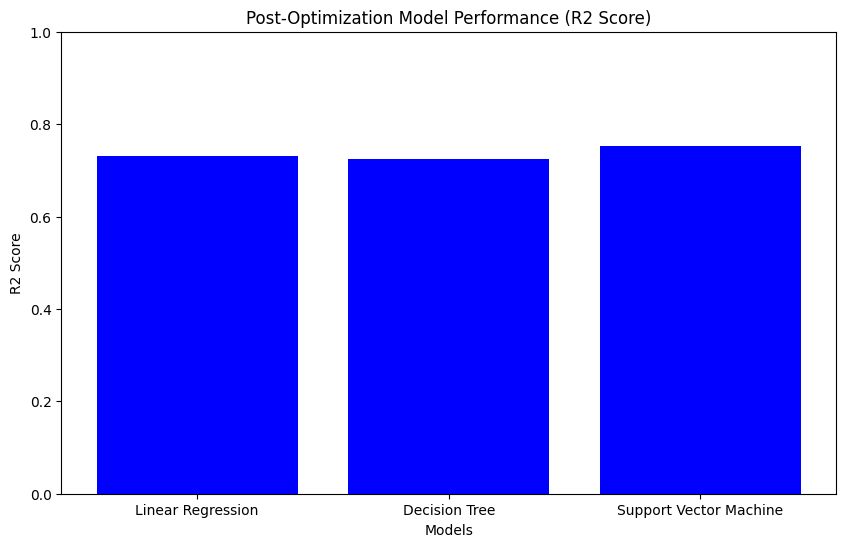

Best Model(s): ['Support Vector Machine']


In [89]:
# 输出每个模型的调优后性能指标
for name, scores in post_optimization_scores.items():
    print(f"\nPost-Optimization Scores for {name}:")
    print(f"MSE: {scores['MSE']}, R2: {scores['R2']}, MAE: {scores['MAE']}")

# 可视化调优后的性能
plt.figure(figsize=(10, 6))
post_optimization_r2_scores = [scores['R2'] for scores in post_optimization_scores.values()]

plt.bar(list(best_models.keys()), post_optimization_r2_scores, color='blue')
plt.title("Post-Optimization Model Performance (R2 Score)")
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.ylim(0, 1)
plt.show()

# 选出具有最高 R2 分数的模型
best_model_names = [name for name, scores in post_optimization_scores.items() if scores['R2'] == max(post_optimization_r2_scores)]
print("Best Model(s):", best_model_names)